# 1. Transfer Learnt Model from model trained on EfficientNet by using Additional layers

| Task                   | Sub-task                                | Comments                                  |
|------------------------|-----------------------------------------|-------------------------------------------|
| Data Preprocessing     | Scaling and Resizing                    | Done                                      |
|                        | Image Augmentation                      | Done                                      |
|                        | Train and test data handled correctly   | Done                                      |
|                        | Gaussian Blur, Histogram Equalization, and Intensity thresholds | Done |
| Model Trained          | Training Time?                         |     20 epochs in 2738 seconds using GPU P100                                 |
|                        | AUC and Confusion Matrix Computed      | Done                                      |
|  |Overfitting/Underfitting checked and handled| Overfitting of one emotion couldn't be handled
| Empirical Tuning       | Interpretability Implemented           | Done                                      |
|                        | 3 Rounds of Tuning |  Done |


In [1]:
# warnings removal
import warnings
warnings.filterwarnings('ignore')

In [35]:
# basic libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

In [30]:
# model evaluation libraries
from sklearn.metrics import confusion_matrix, auc, roc_curve
from itertools import cycle

In [31]:
# model interpretability libraries
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [6]:
# constants
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 6

## 1.1. Data Preprocessing

In [7]:
# preprocessing image
def preprocess_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Gaussian blur
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    # Intensity thresholding
    _, thresholded_img = cv2.threshold(blurred_img, 150, 255, cv2.THRESH_BINARY)
    return cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2BGR)

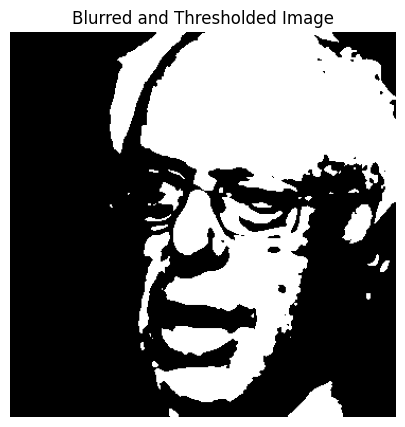

In [8]:
# load the original image
original_image = cv2.imread("/kaggle/input/face-expressions/dataset/Angry/00a7cb9cf18d3a015a9e932952f942fd4bcad8044bcef5e0c05de51d~angry.jpg")  # Replace with the path to your image
final_image = preprocess_image(original_image)

# display the final image
plt.figure(figsize=(10, 5))
plt.imshow(final_image)
plt.title('Blurred and Thresholded Image')
plt.axis('off')
plt.show()

In [9]:
# image augmentation and train-test split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=preprocess_image
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/face-expressions/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/face-expressions/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


## 1.2. Model Building

In [11]:
# creating base model using EfficientNetB0
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)

In [12]:
# adding additional classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [13]:
# creating final model
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# model training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE
)

Epoch 1/20
  1/386 ━━━━━━━━━━━━━━━━━━━━ 11:25:03 107s/step - accuracy: 0.1250 - loss: 2.0074

I0000 00:00:1712257242.181678     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


386/386 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.3738 - loss: 1.5340 - val_accuracy: 0.3721 - val_loss: 1.5792
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4688 - loss: 1.1550 - val_accuracy: 0.3750 - val_loss: 1.5068
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 277s 706ms/step - accuracy: 0.4997 - loss: 1.2600 - val_accuracy: 0.5085 - val_loss: 1.3455
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.4688 - loss: 1.3026 - val_accuracy: 0.5625 - val_loss: 1.0406
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 276s 705ms/step - accuracy: 0.5501 - loss: 1.1369 - val_accuracy: 0.5804 - val_loss: 1.0678
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5312 - loss: 1.1142 - val_accuracy: 0.5625 - val_loss: 0.8635
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 283s 721ms/step - accuracy: 0.5755 - loss: 1.0736 - val_accuracy: 0.5697 - val_loss: 1.1152
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.7812 - loss: 0.8374 - val_acc

In [20]:
# check model losses and accuracies
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Train Loss: {train_loss}, Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}, Accuracy: {test_accuracy}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 207s 536ms/step - accuracy: 0.6476 - loss: 0.8832
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 518ms/step - accuracy: 0.6147 - loss: 1.0347
Train Loss: 0.8913813233375549, Accuracy: 0.6419733166694641
Test Loss: 1.0409600734710693, Accuracy: 0.6052461266517639


## 1.3. Model Tuning

In [18]:
# function to perform tuning
def model_tuning(hidden_layer_nodes=128, batch_size=BATCH_SIZE, epochs=EPOCHS):
    # creating base model using EfficientNetB0
    base_model = EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)
    # adding additional classification layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(hidden_layer_nodes, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    # creating final model
    model = Model(inputs=base_model.input, outputs=predictions)
    # model compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model training
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=train_generator.n // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // batch_size
    )
    return model

In [19]:
# 1st round of tuning
model1 = model_tuning(epochs=30)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 393s 805ms/step - accuracy: 0.3681 - loss: 1.5325 - val_accuracy: 0.3516 - val_loss: 1.5588
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5938 - loss: 1.1172 - val_accuracy: 0.3125 - val_loss: 1.5326
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 259s 662ms/step - accuracy: 0.5198 - loss: 1.2113 - val_accuracy: 0.5277 - val_loss: 1.2722
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.7188 - loss: 0.9670 - val_accuracy: 0.6250 - val_loss: 0.9481
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 258s 660ms/step - accuracy: 0.5441 - loss: 1.1508 - val_accuracy: 0.5472 - val_loss: 1.1671
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.5625 - loss: 1.3127 - val_accuracy: 0.5000 - val_loss: 0.9031
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 269s 686ms/step - accuracy: 0.5674 - loss: 1.0769 - val_accuracy: 0.5426 - val_loss: 1.1854
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5625 - loss: 1.0

In [21]:
# check model losses and accuracies
train_loss1, train_accuracy1 = model1.evaluate(train_generator)
test_loss1, test_accuracy1 = model1.evaluate(validation_generator)
print(f"Train Loss: {train_loss1}, Accuracy: {train_accuracy1}")
print(f"Test Loss: {test_loss1}, Accuracy: {test_accuracy1}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 207s 535ms/step - accuracy: 0.6876 - loss: 0.7996
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 530ms/step - accuracy: 0.6183 - loss: 1.0468
Train Loss: 0.8016660213470459, Accuracy: 0.6839466094970703
Test Loss: 1.033941388130188, Accuracy: 0.6181994676589966


***Comparing untuned model and model trained with 30 epochs, second model tend to overfit more. So, original model with 20 epochs was chosen for further comparison.***

In [22]:
# 2nd round of tuning
model2 = model_tuning(hidden_layer_nodes=256)

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 394s 805ms/step - accuracy: 0.3813 - loss: 1.5013 - val_accuracy: 0.4183 - val_loss: 1.5289
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5000 - loss: 1.4669 - val_accuracy: 0.4375 - val_loss: 1.5728
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 261s 665ms/step - accuracy: 0.5177 - loss: 1.2084 - val_accuracy: 0.5228 - val_loss: 1.1813
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.5938 - loss: 1.1084 - val_accuracy: 0.6875 - val_loss: 1.0797
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 261s 666ms/step - accuracy: 0.5563 - loss: 1.1148 - val_accuracy: 0.5693 - val_loss: 1.1147
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6875 - loss: 1.1447 - val_accuracy: 0.3125 - val_loss: 1.3958
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 262s 670ms/step - accuracy: 0.5740 - loss: 1.0679 - val_accuracy: 0.5622 - val_loss: 1.2105
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.6562 - loss: 0.

In [23]:
# check model losses and accuracies
train_loss2, train_accuracy2 = model2.evaluate(train_generator)
test_loss2, test_accuracy2 = model2.evaluate(validation_generator)
print(f"Train Loss: {train_loss2}, Accuracy: {train_accuracy2}")
print(f"Test Loss: {test_loss2}, Accuracy: {test_accuracy2}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 208s 537ms/step - accuracy: 0.6716 - loss: 0.8204
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 519ms/step - accuracy: 0.6199 - loss: 1.0518
Train Loss: 0.8191078305244446, Accuracy: 0.6710877418518066
Test Loss: 1.016823649406433, Accuracy: 0.6224093437194824


***While performing model tuning with 256 hidden layer nodes, overfitting seemed in reducing stage with high accuracy. So for 3rd round of tuning, same number of hidden layer nodes were used with more epochs upto 30.***

In [24]:
# 3rd round of tuning
model3 = model_tuning(hidden_layer_nodes=256, epochs=30)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 386s 791ms/step - accuracy: 0.3660 - loss: 1.5327 - val_accuracy: 0.3750 - val_loss: 1.6900
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5938 - loss: 1.3456 - val_accuracy: 0.4375 - val_loss: 1.6882
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 264s 673ms/step - accuracy: 0.5163 - loss: 1.2176 - val_accuracy: 0.4587 - val_loss: 1.4003
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.4688 - loss: 1.5978 - val_accuracy: 0.5000 - val_loss: 1.0229
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 265s 676ms/step - accuracy: 0.5558 - loss: 1.1203 - val_accuracy: 0.5560 - val_loss: 1.1208
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5312 - loss: 0.9766 - val_accuracy: 0.8125 - val_loss: 0.9299
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 263s 672ms/step - accuracy: 0.5720 - loss: 1.0774 - val_accuracy: 0.5882 - val_loss: 1.0933
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5625 - loss: 0.8

In [25]:
# check model losses and accuracies
train_loss3, train_accuracy3 = model3.evaluate(train_generator)
test_loss3, test_accuracy3 = model3.evaluate(validation_generator)
print(f"Train Loss: {train_loss3}, Accuracy: {train_accuracy3}")
print(f"Test Loss: {test_loss3}, Accuracy: {test_accuracy3}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 213s 549ms/step - accuracy: 0.6870 - loss: 0.7886
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - accuracy: 0.5966 - loss: 1.1201
Train Loss: 0.791676938533783, Accuracy: 0.686858057975769
Test Loss: 1.0783284902572632, Accuracy: 0.6049222946166992


In [26]:
# select final model
final_model = model2

## 1.4. Model Evaluation

In [27]:
# final model test loss and accuracy
print(f"Loss: {test_loss2}, Accuracy: {test_accuracy2}")

Loss: 1.016823649406433, Accuracy: 0.6224093437194824


In [32]:
# make predictions on the validation generator
y_true = validation_generator.classes
y_pred = np.argmax(final_model.predict(validation_generator), axis=-1)

97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 595ms/step


In [33]:
# confusion matrix generation
conf_matrix = confusion_matrix(y_true, y_pred)

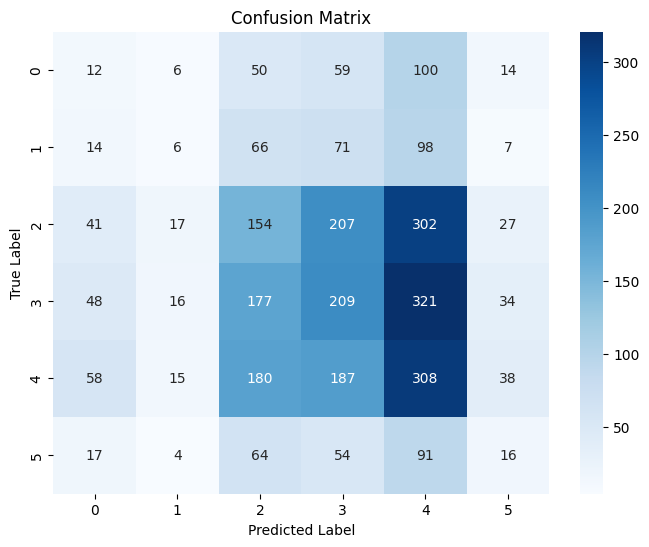

In [36]:
# confusion matrix plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# ROC curve generation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    y_true_binary = (y_true == i)
    y_pred_binary = (y_pred == i)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])

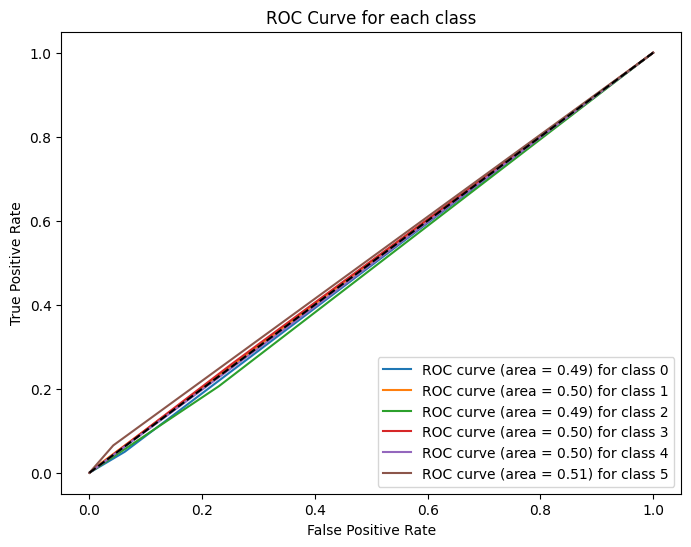

In [39]:
# ROC curve plotting
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()

In [40]:
# create LIME explainer
explainer = lime_image.LimeImageExplainer()

In [42]:
# use sample index
sample_idx = np.random.choice(len(validation_generator))
sample_image, _ = validation_generator[sample_idx]
sample_image = sample_image[0]
true_label = np.argmax(validation_generator.classes[sample_idx])

In [45]:
# create explanation using instance
explanation = explainer.explain_instance(sample_image, final_model.predict, top_labels=NUM_CLASSES, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face Expression: Neutral


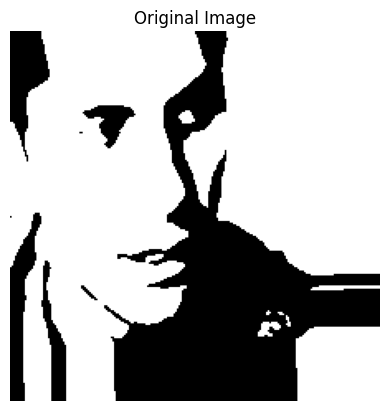

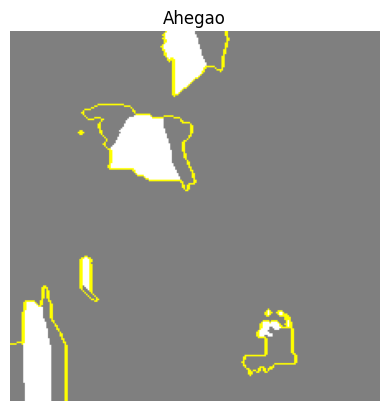

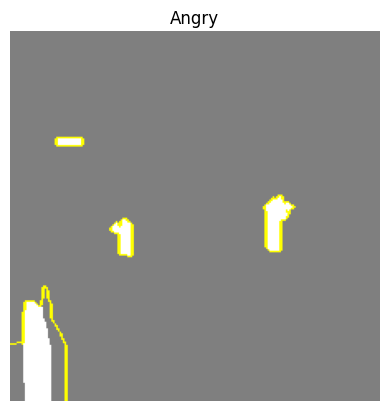

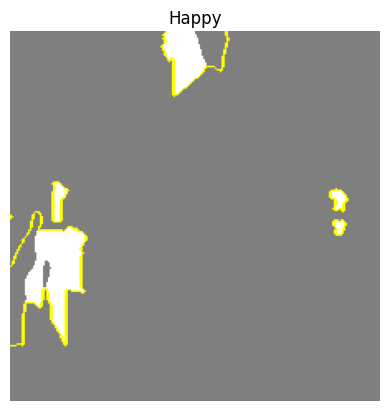

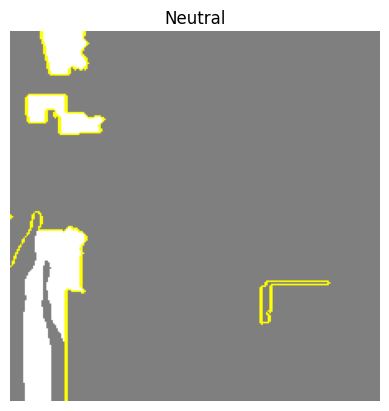

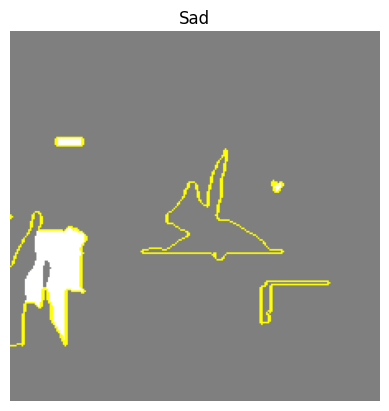

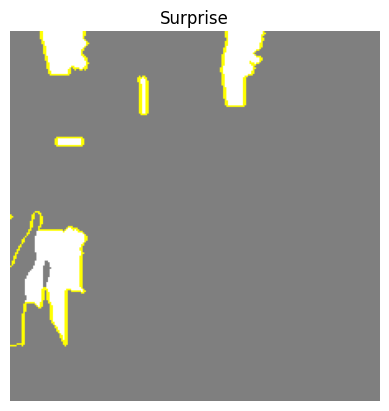

In [47]:
# perform prediction using the model
class_probabilities = model.predict(sample_image.reshape(1, 224, 224, 3))
predicted_class_index = np.argmax(class_probabilities)
predicted_class_name = list(validation_generator.class_indices.keys())[predicted_class_index]
print(f"Face Expression: {predicted_class_name}")

plt.imshow(sample_image)
plt.axis('off')
plt.title('Original Image')
plt.show()

# show LIME explanation
for label_idx in range(6):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[label_idx], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'{list(validation_generator.class_indices.keys())[label_idx]}')
    plt.show()

In [48]:
# saving model
model.save('en_model.h5')